In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os
from PIL import Image
import kaggle
from sklearn.model_selection import train_test_split
import pickle

In [2]:
data_dir = './human-face-emotions/data'

In [ ]:
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode="int",
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=None,
    shuffle=True,
    seed=42
)

class_names = full_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)

Found 57756 files belonging to 5 classes.
Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [4]:
full_data = list(full_ds.as_numpy_iterator())

images = [x[0] for x in full_data]  # list of arrays
labels = [x[1] for x in full_data]  # list of ints

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(
    images, labels,
    test_size=0.30,         # 30% val+test
    random_state=42,
    stratify=labels 
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.50,         # 15% val, 15% test
    random_state=42,
    stratify=y_temp
)

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [7]:
batch_size = 128

train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [ ]:
base = tf.keras.applications.MobileNetV2(
        input_shape=(96, 96, 3),
        include_top=False,
        weights="imagenet"
    )
#base.trainable = False
base.trainable = True
for layer in base.layers[:100]: # pretrained layers for low level patterns
    layer.trainable = False

model = tf.keras.Sequential([
    # preprocessing layers
    tf.keras.layers.Input(shape=(48,48,1)),
    tf.keras.layers.Resizing(96, 96),
    tf.keras.layers.Conv2D(3, (1,1)),  # grayscale -> 3 channels

    base, # 155 layers
    # 2 classification layers
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 121s 355ms/step - accuracy: 0.4350 - loss: 1.4128 - val_accuracy: 0.1385 - val_loss: 4.1534
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 107s 337ms/step - accuracy: 0.7291 - loss: 0.7746 - val_accuracy: 0.1407 - val_loss: 4.2808
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 107s 337ms/step - accuracy: 0.8756 - loss: 0.4367 - val_accuracy: 0.1585 - val_loss: 4.0046
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 113s 357ms/step - accuracy: 0.9484 - loss: 0.2249 - val_accuracy: 0.2613 - val_loss: 3.2164
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 105s 331ms/step - accuracy: 0.9799 - loss: 0.1120 - val_accuracy: 0.3644 - val_loss: 2.5924
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 108s 341ms/step - accuracy: 0.9915 - loss: 0.0616 - val_accuracy: 0.4938 - val_loss: 1.9546
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 107s 339ms/step - accuracy: 0.9934 - loss: 0.0458 - val_accuracy: 0.6170 - val_loss: 1.4257
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 110s 349ms/step - accuracy: 0.9933 -

In [22]:
test_loss, test_acc = model.evaluate(test_ds)
print("Final Test Accuracy:", test_acc)

68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.8077 - loss: 0.8289
Final Test Accuracy: 0.8047091364860535


In [ ]:
model.save('models/transfer_cnn.keras')

In [ ]:
with open("training_history/history_transfer_cnn.pkl", "wb") as f:
    pickle.dump(history.history, f)

### Same model but all layers frozen (for comparison)

In [ ]:
base_frz = tf.keras.applications.MobileNetV2(
        input_shape=(96, 96, 3),
        include_top=False,
        weights="imagenet"
    )
base_frz.trainable = False

model_frz = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48,48,1)),
    tf.keras.layers.Resizing(96, 96),
    tf.keras.layers.Conv2D(3, (1,1)),

    base_frz,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_frz.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
history_frz = model_frz.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 86s 254ms/step - accuracy: 0.2326 - loss: 1.9714 - val_accuracy: 0.3144 - val_loss: 1.5517
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 86s 273ms/step - accuracy: 0.3275 - loss: 1.5411 - val_accuracy: 0.3417 - val_loss: 1.5131
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 85s 268ms/step - accuracy: 0.3520 - loss: 1.5013 - val_accuracy: 0.3649 - val_loss: 1.4870
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 86s 271ms/step - accuracy: 0.3693 - loss: 1.4744 - val_accuracy: 0.3723 - val_loss: 1.4711
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 87s 275ms/step - accuracy: 0.3771 - loss: 1.4623 - val_accuracy: 0.3731 - val_loss: 1.4599
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 91s 288ms/step - accuracy: 0.3884 - loss: 1.4468 - val_accuracy: 0.3862 - val_loss: 1.4498
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 90s 284ms/step - accuracy: 0.3972 - loss: 1.4329 - val_accuracy: 0.3834 - val_loss: 1.4428
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 89s 282ms/step - accuracy: 0.4056 - loss: 1

In [ ]:
model_frz.save('models/transfer_frozen_cnn.keras')

In [ ]:
with open("training_history/history_transfer_cnn_frozen.pkl", "wb") as f:
    pickle.dump(history_frz.history, f)

### Ananysis

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━

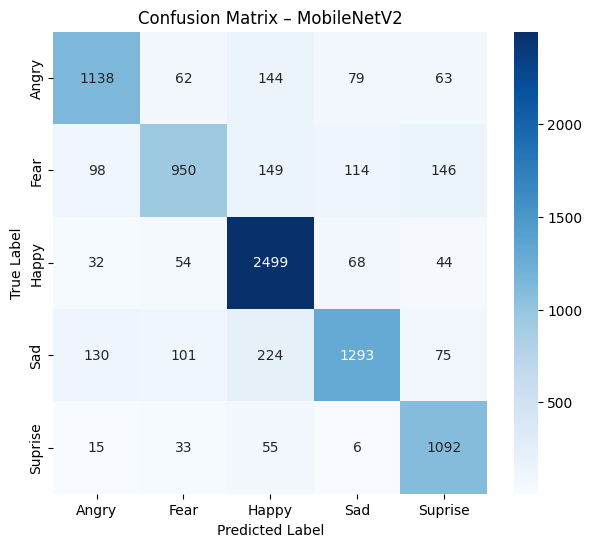

In [26]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – MobileNetV2")
plt.savefig("visuals/mobilenet_confusion_matrix.png")
plt.show()

In [ ]:
confusions = []

for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            confusions.append((cm[i][j], class_names[i], class_names[j]))

confusions_sorted = sorted(confusions, reverse=True)

print("Top confusion pairs:")
for count, true_label, pred_label in confusions_sorted[:30]:
    print(f"{true_label} → {pred_label}: {count}")

Top confusion pairs:
Sad → Happy: 224
Fear → Happy: 149
Fear → Suprise: 146
Angry → Happy: 144
Sad → Angry: 130
Fear → Sad: 114
Sad → Fear: 101
Fear → Angry: 98
Angry → Sad: 79
Sad → Suprise: 75
Happy → Sad: 68
Angry → Suprise: 63
Angry → Fear: 62
Suprise → Happy: 55
Happy → Fear: 54
Happy → Suprise: 44
Suprise → Fear: 33
Happy → Angry: 32
Suprise → Angry: 15
Suprise → Sad: 6


In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.81      0.77      0.79      1486
        Fear       0.79      0.65      0.72      1457
       Happy       0.81      0.93      0.87      2697
         Sad       0.83      0.71      0.76      1823
     Suprise       0.77      0.91      0.83      1201

    accuracy                           0.80      8664
   macro avg       0.80      0.79      0.79      8664
weighted avg       0.81      0.80      0.80      8664

